## U shape PHP dynamics with multiple liquid slugs - with heat transfer

## $\frac{\partial \theta }{\partial \mathcal{T}} = \nabla^2 \theta$

In [1]:
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
using DifferentialEquations

In [3]:
using CartesianGrids

In [4]:
cd(dirname(pwd()))
cd("src") 


include("Systems.jl")
using ..Systems

include("Tools.jl")
using ..Tools


include("Thermomodel.jl")
using ..Thermomodel

include("Postprocessing.jl")
using ..Postprocessing

cd(dirname(pwd()))

In [5]:
function ifamongone(value::Float64, range::Tuple{Float64,Float64})
    return (value >= range[1]) && (value <= range[2]) ? true : false
end

ifamongone (generic function with 1 method)

In [6]:
function ifamong(value::Float64, X::Array{Tuple{Float64,Float64},1})
    
    return Bool(sum(ifamongone.(value,X)))
end

ifamong (generic function with 1 method)

In [7]:
function settemperature!(θᵣ,xvalue,sys0)
    
    if ifamong(xvalue, sys0.evaporator.Xe)
        θᵣ = sys0.evaporator.θe

    elseif ifamong(xvalue, sys0.condenser.Xc)
        θᵣ = sys0.condenser.θc
    end

    return θᵣ
    
end

settemperature! (generic function with 1 method)

In [8]:
function oneDlaplacian(x,sys0)
    N = size(x,1)
    twoDx =  Nodes(Dual,(N,5))
    
    α = sys0.tube.α
    
    twoDx[:,1] = x
    twoDx[:,2] = twoDx[:,1]
    twoDx[:,3] = twoDx[:,1]
    twoDx[:,4] = twoDx[:,1]
    twoDx[:,5] = twoDx[:,1]
    
    laptwoDx = Nodes(Dual,(N,5))
    laponeDx = Nodes(Dual,(N,1))
    
    laptwoDx = α*laplacian(twoDx)
    
    laponeDx .= laptwoDx[:,3]
    
    return laponeDx
end

oneDlaplacian (generic function with 1 method)

## Parameters of the PHP

In [9]:
    ω0 = [sqrt(1.2e004), sqrt(1.2e004),sqrt(1.2e004), sqrt(1.2e004),sqrt(1.2e004), sqrt(1.2e004),sqrt(1.2e004), sqrt(1.2e004)];
    ℘ = [1.2e005, 1.2e005,1.2e005, 1.2e005,1.2e005, 1.2e005,1.2e005, 1.2e005];


     θ = 0.15;
    θe = 1 + θ;
    θc = 1 - θ;
    
    He = 3000.0;
    Hc = 3000.0;
    
    X0 = 0.5;

    γ = 1.4;

In [10]:
    L = 24.0  # total length of the pipe when streched to a 1D pipe
    L2D = 2.0 # the actual length of the bended pipe in the real world
    angle = pi/2 # inclination angle 
    α = 5 # nondimensional thermal diffusivity = (αₐ d^2) / (νₗ height^2)

5

## Pipe definition

In [11]:
tube = Tube(L,L2D,angle,α)

Tube(24.0, 2.0, 1.5707963267948966, 5.0)

## Evaporator and condenser definition

In [12]:
Xe = map(tuple, [0.0; 3.75; 7.75; 11.75; 15.75; 19.75; 23.75], [0.25; 4.25; 8.25; 12.25; 16.25; 20.25; 24.0])
evap = Evaporator(He,θe,Xe)

Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 0.25), (3.75, 4.25), (7.75, 8.25), (11.75, 12.25), (15.75, 16.25), (19.75, 20.25), (23.75, 24.0)])

In [13]:
Xc = map(tuple, [1.75; 5.75; 9.75; 13.75; 17.75; 21.75], [2.25; 6.25; 10.25; 14.25; 18.25; 22.25])
cond = Condenser(Hc,θc,Xc)

Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.75, 2.25), (5.75, 6.25), (9.75, 10.25), (13.75, 14.25), (17.75, 18.25), (21.75, 22.25)])

## Vapor plug and liquid slug initialization

In [14]:
X0 = [(0.5,2.5),(5.0,7.0),(7.5,8.0),(9.0,12.0),(14.0,15.0),(16.2,17.6),(20.0,21.0),(21.6,23.2)]
dXdt0 = [(0.0,0.0),(0.0,0.0),(0.0,0.0),(0.0,0.0),(0.0,0.0),(0.0,0.0),(0.0,0.0),(0.0,0.0)]
liquids=LiquidSlug(γ,ω0,℘,X0,dXdt0)

LiquidSlug(1.4, [109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323], [120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0), (7.5, 8.0), (9.0, 12.0), (14.0, 15.0), (16.2, 17.6), (20.0, 21.0), (21.6, 23.2)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)])

In [15]:
P = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0];
vapors=VaporPlug(γ,P)

VaporPlug(1.4, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Construct the system

In [16]:
sys0 = PHPSystem(tube,evap,cond,liquids,vapors)

PHPSystem(Tube(24.0, 2.0, 1.5707963267948966, 5.0), Evaporator(3000.0, 1.15, Tuple{Float64,Float64}[(0.0, 0.25), (3.75, 4.25), (7.75, 8.25), (11.75, 12.25), (15.75, 16.25), (19.75, 20.25), (23.75, 24.0)]), Condenser(3000.0, 0.85, Tuple{Float64,Float64}[(1.75, 2.25), (5.75, 6.25), (9.75, 10.25), (13.75, 14.25), (17.75, 18.25), (21.75, 22.25)]), LiquidSlug(1.4, [109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323, 109.54451150103323], [120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0, 120000.0], Tuple{Float64,Float64}[(0.5, 2.5), (5.0, 7.0), (7.5, 8.0), (9.0, 12.0), (14.0, 15.0), (16.2, 17.6), (20.0, 21.0), (21.6, 23.2)], Tuple{Float64,Float64}[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]), VaporPlug(1.4, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]))

In [17]:
typeof(sys0)

PHPSystem

## Construct U for wall heat function

In [18]:
N = 1000

x = Nodes(Dual,(N,1))
x .= LinRange(0, sys0.tube.L, N)

θᵣ = Nodes(Dual,(N,1))
θᵣ .= reshape(ones(N),N,1)
θᵣ .= settemperature!.(θᵣ,x,[sys0])

Nodes{Dual,1000,1,Float64,Array{Float64,2}} data
Printing in grid orientation (lower left is (1,1))
1×1000 Array{Float64,2}:
 1.15  1.15  1.15  1.15  1.15  1.15  …  1.15  1.15  1.15  1.15  1.15  1.15

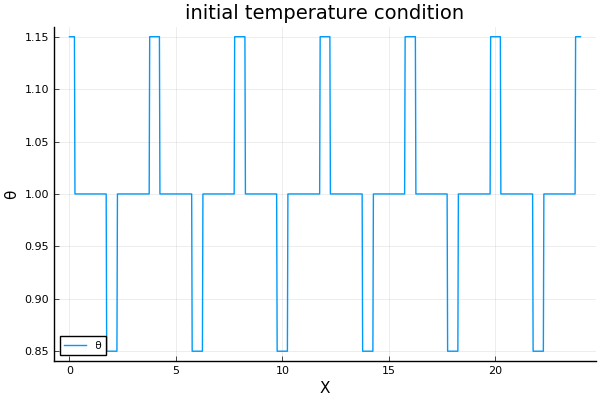

In [19]:
plot([x],[θᵣ], title="initial temperature condition", labels = "θ", xlabel="X", ylabel="θ")

## Solve the constructed ODE for U

### propagation function

In [20]:
function dfdt(u,p,t)
 du = oneDlaplacian(u,p)
end


dfdt (generic function with 1 method)

### condition

In [21]:
function condition(u,t,integrator)
    true
end

condition (generic function with 1 method)

### affect! (with boundary conditions)

In [22]:
function affect!(integrator)
    θᵣtemp = deepcopy(integrator.u)
    
    θᵣtemp .= settemperature!.(integrator.u,x,[sys0])
    
    set_u!(integrator,  θᵣtemp)
end

affect! (generic function with 1 method)

In [23]:
cb = DiscreteCallback(condition,affect!)

DiscreteCallback{typeof(condition),typeof(affect!),typeof(DiffEqBase.INITIALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, Bool[1, 1])

In [24]:
tstep=1e-2

p = sys0
tspan = (0.0, 30.0);
prob = ODEProblem(dfdt, θᵣ, tspan, p)

# integrator = init(prob, RK4(), adaptive=false, dt=tstep, );
sol = solve(prob, RK4(), adaptive=false, dt=tstep, callback=cb, save_everystep=false);

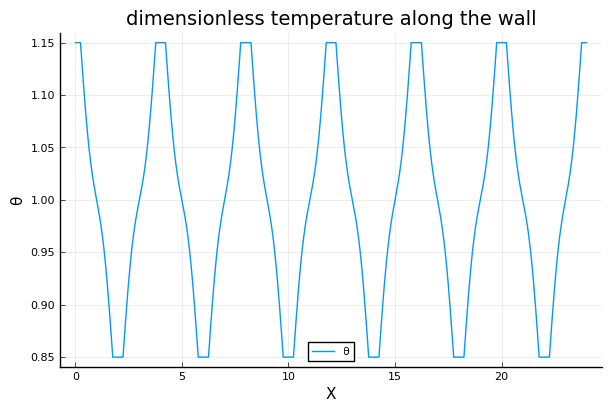

┌ Info: Saved animation to 
│   fn = C:\Users\liyux\Documents\GitHub\OneDThermalFlow\tmp.gif
└ @ Plots C:\Users\liyux\.juliapro\JuliaPro_v1.3.1-2\packages\Plots\ninUP\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\liyux\\Documents\\GitHub\\OneDThermalFlow\\tmp.gif")
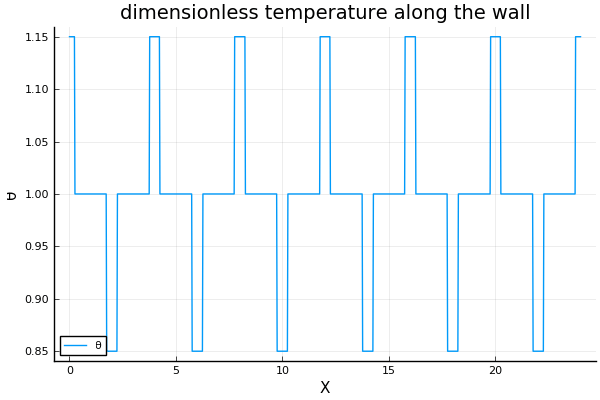

In [25]:
@gif for i=1:size(sol,3)
plot([x],[sol[i]], labels = "θ", xlabel="X", ylabel="θ", title=("dimensionless temperature along the wall"))
    end every 100